# Complementary extra codes: Find duplicate candidates

Author: Thiago Nascimento (thiago.nascimento@eawag.ch)

This notebook complements the EStreams publication and can be used to find potential duplicated catchments within the dataset, following the criterion described in the EStreams manuscript.

* Note that this code enables not only the replicability of the current database but also the extrapolation to new catchment areas. 
* Additionally, the user should download and insert the original raw-data in the folder of the same name prior to run this code. 
* The original third-party data used were not made available in this repository due to redistribution and storage-space reasons.  

## Requirements
**Python:**

* Python>=3.6
* Jupyter
* geopandas=0.10.2
* numpy
* os
* pandas
* shapely
* textdistance
* tqdm
* warnings

Check the Github repository for an environment.yml (for conda environments) or requirements.txt (pip) file.

**Files:**

* data/streamflow/estreams_gauging_stations.csv

**Directory:**

* Clone the GitHub directory locally
* Place any third-data variables in their respective directory.
* ONLY update the "PATH" variable in the section "Configurations", with their relative path to the EStreams directory. 


## Observations
* As this step is rather qualitative, we believe that the users can also adapt the conditons accordinly to their needs. 


# Import modules

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import tqdm as tqdm
import os
import warnings
import textdistance
from shapely.geometry import Point

# Configurations

In [2]:
# Only editable variable:
# Relative path to your local directory
PATH = "../../.."

# Suppress all warnings
warnings.filterwarnings("ignore")

# Constrains
JARO_THRESHOLD = 0.7
SPATIAL_THRESHOLD = 1000
PROVIDER_THRESHOLD = 0.9
SPATIAL_PROVIDER_THRESHOLD = 50
AREA_THRESHOLD = 0.01

* #### The users should NOT change anything in the code below here.


In [3]:
# Non-editable variables:
PATH_OUTPUT = "results/"
# Set the directory:
os.chdir(PATH)

# Import data
## Streamflow gauges network

In [4]:
network_estreams = pd.read_csv('results/estreams_gauging_stations.csv', encoding='utf-8')
network_estreams.set_index("basin_id", inplace = True)
network_estreams

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,area,...,num_months,num_days,num_days_gaps,num_continuous_days,geometry,duplicated_suspect,watershed_group,gauges_upstream,gauge_downstream,nested_catchments
basin_id,,,,,,,,,,,,,,,,,,,,,
AT000001,200014,Bangs,AT,AT_EHYD,Rhein,9.534835,47.273748,9.534835,47.273748,4647.9,...,312,9497,0.0,9497,POINT (9.534835180274024 47.27374823144418),CH000197,1,14,AT000013,"['AT000001', 'CH000010', 'CH000046', 'CH000048..."
AT000002,200048,Schruns (Vonbunweg),AT,AT_EHYD,Litz,9.913677,47.080301,9.913677,47.080301,102.0,...,759,23103,0.0,23103,POINT (9.913676603393986 47.08030125096045),CH000221,1,1,CH000221,['AT000002']
AT000003,231662,Loruens-Aeule,AT,AT_EHYD,Ill,9.847765,47.132821,9.847765,47.132821,535.2,...,444,13513,0.0,13513,POINT (9.847765104487962 47.13282061553542),CH000215,1,2,CH000215,"['AT000002', 'AT000003', 'CH000221']"
AT000004,200592,Kloesterle (OEBB),AT,AT_EHYD,Alfenz,10.061843,47.128994,10.061843,47.128994,66.6,...,288,8765,0.0,8765,POINT (10.06184292326845 47.1289938468501),CH000227,1,1,CH000227,['AT000004']
AT000005,200097,Buers (Bruecke L82),AT,AT_EHYD,Alvier,9.802668,47.150770,9.802668,47.150770,72.2,...,360,10957,0.0,10957,POINT (9.802668269683238 47.15077039253907),CH000214,1,1,CH000214,"['AT000005', 'CH000214']"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UAGR0017,6682300,BASHTANOVKA,UA,UA_GRDC,KACHA,33.894739,44.691884,33.900000,44.683333,321.0,...,120,3652,0.0,3652,POINT (33.9 44.683333),NaN,1988,1,NaN,['UAGR0017']
UAGR0018,6682500,YALTA,UA,UA_GRDC,DERE-KIOY,34.166667,44.500000,34.166667,44.500000,49.7,...,120,3652,0.0,3652,POINT (34.166667 44.5),NaN,1989,1,NaN,['UAGR0018']
UAGR0019,6683010,PIONERSKOE,UA,UA_GRDC,SALHYR,34.199841,44.887685,34.200000,44.883333,261.0,...,120,3652,0.0,3652,POINT (34.2 44.883333),NaN,1990,1,NaN,['UAGR0019']


# Processing
- Pre-process the dataset

In [5]:
# If we want to clip the data to be used:
df = network_estreams.iloc[:, :]

# Create a GeoDataFrame from DataFrame with WGS 84 coordinates
geometry = [Point(lon, lat) for lon, lat in zip(network_estreams['lon'], network_estreams['lat'])]
gdf_wgs84 = gpd.GeoDataFrame(network_estreams, geometry=geometry, crs='EPSG:4326')

# Reproject the GeoDataFrame to ETRS89 LAEA (EPSG:3035)
gdf_etrs89 = gdf_wgs84.to_crs(epsg=3035)

df = gdf_etrs89.loc[df.index, :]

- Compute the distances

In [6]:
# Create a dictionary to store distances
distances = {}

# Calculate Jaro-Winkler distance for each unique pair of 'gauge_name'
for i, row1 in tqdm.tqdm(df.iterrows()):
    for j, row2 in gdf_etrs89.iterrows():
        # Skip self-comparisons
        if i != j:
            # Calculate gauge name distance
            try:
                gauge_distance = textdistance.jaro_winkler(row1['gauge_name'].lower(), row2['gauge_name'].lower())
            except:
                gauge_distance = np.nan
                
            # Calculate river distance
            try:
                river_distance = textdistance.jaro_winkler(row1['river'].lower(), row2['river'].lower())
            except:
                river_distance = np.nan
                
            provider_distance = row1['gauge_provider'].lower() == row2['gauge_provider'].lower()          
        
            # Calculate distance between points
            point1 = row1['geometry']
            point2 = row2['geometry']
            point_distance = point1.distance(point2)
            
            # Calculate area_calc difference
            area_calc_diff = abs(row1['area_calc'] - row2['area_calc']) / max(row1['area_calc'], row2['area_calc'])
            
            # Store distances along with first and second gauge indices only if gauge_distance > 0.9
            if (gauge_distance > JARO_THRESHOLD) & (river_distance > JARO_THRESHOLD) & (point_distance < SPATIAL_THRESHOLD) & (provider_distance == False):
                distances[(row1['gauge_name'], row2['gauge_name'])] = {
                    'gauge_first_index': i, 
                    'gauge_second_index': j,
                    'gauge_distance': gauge_distance, 
                    'river_distance': river_distance,
                    'point_distance': point_distance,
                    'provider_distance': provider_distance
                }
                
            # Additional condition: if provider_distance is True and point_distance < 250m and area_calc_diff <= 0.01
            if provider_distance and point_distance < SPATIAL_PROVIDER_THRESHOLD and area_calc_diff <= AREA_THRESHOLD:
                distances[(row1['gauge_name'], row2['gauge_name'])] = {
                    'gauge_first_index': i,
                    'gauge_second_index': j,
                    'gauge_distance': gauge_distance,
                    'river_distance': river_distance,
                    'point_distance': point_distance,
                    'provider_distance': provider_distance
                }

# Convert dictionary to DataFrame for visualization
dist_df = pd.DataFrame.from_dict(distances, orient='index')
dist_df.index.names = ['gauge_name1', 'gauge_name2']
dist_df.reset_index(inplace=True)

17130it [6:01:59,  1.27s/it]


- Quick overview of the results

In [7]:
# Number of duplicates (considering only first row, so not necessarly accurate)
len(dist_df.gauge_first_index.unique())

776

In [8]:
# Overview of the distances table
dist_df[0:100]

,gauge_name1,gauge_name2,gauge_first_index,gauge_second_index,gauge_distance,river_distance,point_distance,provider_distance
0,Bangs,Bangs,CH000197,AT000001,1.000000,1.000000,554.431769,False
1,Schruns (Vonbunweg),Schruns_(Vonbunweg),AT000002,CH000221,0.978947,1.000000,281.435851,False
2,Loruens-Aeule,Loruens-Aeule,CH000215,AT000003,1.000000,1.000000,356.336721,False
3,Kloesterle (OEBB),Kloesterle_(OEBB),AT000004,CH000227,0.976471,1.000000,179.092492,False
4,Buers (Bruecke L82),Buers_(Bruecke_L82),AT000005,CH000214,0.957895,1.000000,219.861947,False
...,...,...,...,...,...,...,...,...
95,BOHUNOVSKO-JESENNY,Bohuňovsko-Jesenný,CZGR0005,CZ000085,0.955556,1.000000,5.129357,False
96,NEMETICE,Němětice,CZGR0006,CZ000138,0.850000,0.942857,5.883213,False
97,BEROUN,Beroun,CZGR0007,CZ000217,1.000000,1.000000,2.177231,False
98,TEPLICKA,Teplička,CZGR0008,CZ000257,0.950000,0.920000,2.720590,False


In [9]:
# Check the gauge with the most duplicated suspects
most_common_name = dist_df['gauge_first_index'].value_counts().idxmax()

print("The most common name in the column is:", most_common_name)

The most common name in the column is: FR000504


In [10]:
# Check it out
dist_df[dist_df.gauge_first_index == "FR000504"]

,gauge_name1,gauge_name2,gauge_first_index,gauge_second_index,gauge_distance,river_distance,point_distance,provider_distance
469,NaN,H5201014,FR000504,FR000501,NaN,1.000000,21.943272,True
470,NaN,H5201013,FR000504,FR000502,NaN,1.000000,21.943272,True
471,NaN,H5201010,FR000504,FR000503,NaN,1.000000,21.943272,True
472,NaN,H5201011,FR000504,FR000505,NaN,0.848211,21.943272,True


In [11]:
dist_df[dist_df.provider_distance == True][dist_df.point_distance <= 10]

,gauge_name1,gauge_name2,gauge_first_index,gauge_second_index,gauge_distance,river_distance,point_distance,provider_distance
83,Zlín,Zlín+svod,CZ000449,CZ000451,0.888889,1.0,3.029888,True
84,Zlín+svod,Zlín,CZ000451,CZ000449,0.888889,1.0,3.029888,True
124,Gr. Wittensee,Gr. Wittensee-Mühlenbek,DESH1368,DESH1369,0.913043,1.0,3.164049,True
125,Gr. Wittensee-Mühlenbek,Gr. Wittensee,DESH1369,DESH1368,0.913043,1.0,3.164049,True
128,Grafhorst 2,Grafhorst 3,DENI1865,DENI1866,0.963636,1.0,0.000000,True
...,...,...,...,...,...,...,...,...
831,MALPILS,BUBS,LVGR0024,LVGR0014,0.000000,0.0,0.000000,True
837,PIASECZNO 1,PIASECZNO 2,PL000920,PL000921,0.963636,1.0,0.000000,True
838,PIASECZNO 2,PIASECZNO 1,PL000921,PL000920,0.963636,1.0,0.000000,True
839,ROGÓŹNO 2,ROGÓŹNO 1,PL001194,PL001195,0.955556,1.0,7.715592,True


In [12]:
dist_df[dist_df.provider_distance == True].head(50)

,gauge_name1,gauge_name2,gauge_first_index,gauge_second_index,gauge_distance,river_distance,point_distance,provider_distance
33,Durby,Durbuy,BEWA0012,BEWA0176,0.966667,0.885714,49.667564,True
34,BerslilliersLAbbaye,BrsilliesLAbbaye,BEWA0041,BEWA0170,0.840132,1.000000,23.341560,True
35,Yvoir,Yvoir,BEWA0188,BEWA0042,1.000000,1.000000,42.141533,True
36,Isieres,Isières,BEWA0075,BEWA0180,0.894444,1.000000,25.717922,True
37,Ronquieres,Ronquières,BEWA0091,BEWA0181,0.937778,1.000000,48.709906,True
38,SaintRemyGeest,SaintRémyGeest,BEWA0093,BEWA0182,0.940659,0.983333,12.387163,True
39,VillerDevantOrval,VillersDevantOrval,BEWA0110,BEWA0183,0.988889,1.000000,41.916037,True
40,Bistian,Bistain,BEWA0132,BEWA0172,0.971429,0.888638,38.501916,True
41,BrsilliesLAbbaye,BerslilliersLAbbaye,BEWA0170,BEWA0041,0.840132,1.000000,23.341560,True
42,Bistain,Bistian,BEWA0172,BEWA0132,0.971429,0.888638,38.501916,True


In [13]:
dist_df[dist_df.gauge_first_index == "ITLI0307"]

,gauge_name1,gauge_name2,gauge_first_index,gauge_second_index,gauge_distance,river_distance,point_distance,provider_distance
817,CALAMAZZA,Calamazza,ITLI0307,ITTO0386,1.00,1.0,51.945958,False
818,CALAMAZZA,Calamazza ARPAL,ITLI0307,ITTO0389,0.92,1.0,423.716013,False


In [14]:
# Gauges located in different providers
dist_df[dist_df.provider_distance == False]

,gauge_name1,gauge_name2,gauge_first_index,gauge_second_index,gauge_distance,river_distance,point_distance,provider_distance
0,Bangs,Bangs,CH000197,AT000001,1.000000,1.000000,554.431769,False
1,Schruns (Vonbunweg),Schruns_(Vonbunweg),AT000002,CH000221,0.978947,1.000000,281.435851,False
2,Loruens-Aeule,Loruens-Aeule,CH000215,AT000003,1.000000,1.000000,356.336721,False
3,Kloesterle (OEBB),Kloesterle_(OEBB),AT000004,CH000227,0.976471,1.000000,179.092492,False
4,Buers (Bruecke L82),Buers_(Bruecke_L82),AT000005,CH000214,0.957895,1.000000,219.861947,False
...,...,...,...,...,...,...,...,...
820,Calamazza,CALAMAZZA,ITTO0386,ITLI0307,1.000000,1.000000,51.945958,False
821,Calamazza ARPAL,CALAMAZZA,ITTO0389,ITLI0307,0.920000,1.000000,423.716013,False
832,CHAŁUPKI,Chalupki,PL000001,CZ000344,0.941667,0.900000,3.567275,False
833,BRANICE,Branice,PL000030,CZ000311,1.000000,0.804848,17.213067,False


<AxesSubplot:>

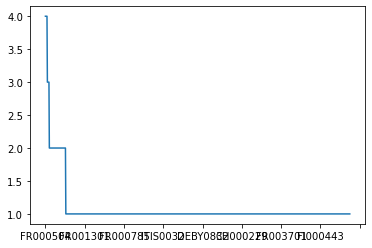

In [15]:
# Just a visual inspection of the results
dist_df['gauge_first_index'].value_counts().plot()

### Here we add the list of duplicated suspects

In [16]:
network_estreams["duplicated_suspect"] = np.nan

In [17]:
# Loop over the first column:
for gauge in tqdm.tqdm(dist_df.gauge_first_index):
    
    duplicated_list = str(dist_df.gauge_second_index[dist_df.gauge_first_index == gauge].tolist()).replace("[", "")
    duplicated_list = duplicated_list.replace("]", "")
    duplicated_list = duplicated_list.replace("'", "")
    network_estreams.loc[gauge, "duplicated_suspect"] = duplicated_list
    network_estreams.loc[gauge, "duplicated_suspect"] = network_estreams.loc[gauge, "duplicated_suspect"]

100%|██████████████████████████████████████████████████████████████████████████████| 843/843 [00:00<00:00, 4481.91it/s]


In [18]:
# Loop over the second column:
for gauge in tqdm.tqdm(dist_df.gauge_second_index):
    
    duplicated_list = str(dist_df.gauge_first_index[dist_df.gauge_second_index == gauge].tolist()).replace("[", "")
    duplicated_list = duplicated_list.replace("]", "")
    duplicated_list = duplicated_list.replace("'", "")
    network_estreams.loc[gauge, "duplicated_suspect"] = duplicated_list
    network_estreams.loc[gauge, "duplicated_suspect"] = network_estreams.loc[gauge, "duplicated_suspect"]

100%|██████████████████████████████████████████████████████████████████████████████| 843/843 [00:00<00:00, 4493.33it/s]


In [19]:
# Adjust the duplicated_suspect column
network_estreams['duplicated_suspect'] = network_estreams['duplicated_suspect'].str.replace(r'\s*,\s*', ',')
network_estreams['duplicated_suspect'] = network_estreams['duplicated_suspect'].str.split(',')
network_estreams

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,area,...,num_months,num_days,num_days_gaps,num_continuous_days,geometry,duplicated_suspect,watershed_group,gauges_upstream,gauge_downstream,nested_catchments
basin_id,,,,,,,,,,,,,,,,,,,,,
AT000001,200014,Bangs,AT,AT_EHYD,Rhein,9.534835,47.273748,9.534835,47.273748,4647.9,...,312,9497,0.0,9497,POINT (9.53484 47.27375),[CH000197],1,14,AT000013,"['AT000001', 'CH000010', 'CH000046', 'CH000048..."
AT000002,200048,Schruns (Vonbunweg),AT,AT_EHYD,Litz,9.913677,47.080301,9.913677,47.080301,102.0,...,759,23103,0.0,23103,POINT (9.91368 47.08030),[CH000221],1,1,CH000221,['AT000002']
AT000003,231662,Loruens-Aeule,AT,AT_EHYD,Ill,9.847765,47.132821,9.847765,47.132821,535.2,...,444,13513,0.0,13513,POINT (9.84777 47.13282),[CH000215],1,2,CH000215,"['AT000002', 'AT000003', 'CH000221']"
AT000004,200592,Kloesterle (OEBB),AT,AT_EHYD,Alfenz,10.061843,47.128994,10.061843,47.128994,66.6,...,288,8765,0.0,8765,POINT (10.06184 47.12899),[CH000227],1,1,CH000227,['AT000004']
AT000005,200097,Buers (Bruecke L82),AT,AT_EHYD,Alvier,9.802668,47.150770,9.802668,47.150770,72.2,...,360,10957,0.0,10957,POINT (9.80267 47.15077),[CH000214],1,1,CH000214,"['AT000005', 'CH000214']"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UAGR0017,6682300,BASHTANOVKA,UA,UA_GRDC,KACHA,33.894739,44.691884,33.900000,44.683333,321.0,...,120,3652,0.0,3652,POINT (33.90000 44.68333),NaN,1988,1,NaN,['UAGR0017']
UAGR0018,6682500,YALTA,UA,UA_GRDC,DERE-KIOY,34.166667,44.500000,34.166667,44.500000,49.7,...,120,3652,0.0,3652,POINT (34.16667 44.50000),NaN,1989,1,NaN,['UAGR0018']
UAGR0019,6683010,PIONERSKOE,UA,UA_GRDC,SALHYR,34.199841,44.887685,34.200000,44.883333,261.0,...,120,3652,0.0,3652,POINT (34.20000 44.88333),NaN,1990,1,NaN,['UAGR0019']


## Analysis of the duplicates
- At this part we have the correct analysis, rater than the previous estimatives.

In [20]:
print("The number of duplicates suspects is", network_estreams.duplicated_suspect.count())

The number of duplicates suspects is 885


In [21]:
network_estreams[network_estreams.gauge_country=="LV"].head(50)

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,area,...,num_months,num_days,num_days_gaps,num_continuous_days,geometry,duplicated_suspect,watershed_group,gauges_upstream,gauge_downstream,nested_catchments
basin_id,,,,,,,,,,,,,,,,,,,,,
LVGR0001,6372100,VALMIERA,LV,LV_GRDC,KOIVA JOGI,25.423400,57.536200,25.423400,57.536200,6280.0,...,501,15249,457.0,8401,POINT (25.42340 57.53620),NaN,507,8,LVGR0003,"['EEGR0064', 'LVGR0002', 'LVGR0004', 'LVGR0010..."
LVGR0002,6372103,TILDERI,LV,LV_GRDC,KOIVA JOGI,26.350000,57.450000,26.350000,57.450000,2230.0,...,60,1826,1826.0,731,POINT (26.35000 57.45000),NaN,507,4,LVGR0001,"['LVGR0004', 'LVGR0011', 'LVGR0013']"
LVGR0003,6372104,SIGULDA,LV,LV_GRDC,KOIVA JOGI,24.841719,57.165364,24.841719,57.165364,8510.0,...,60,1826,1826.0,731,POINT (24.84172 57.16536),NaN,507,10,NaN,"['EEGR0064', 'LVGR0001', 'LVGR0002', 'LVGR0003..."
LVGR0004,6372111,OLI,LV,LV_GRDC,TULIJA,25.908305,57.151893,25.910000,57.150000,40.0,...,48,1460,2192.0,730,POINT (25.91000 57.15000),NaN,507,1,LVGR0011,['LVGR0004']
LVGR0005,6372941,TERANDA,LV,LV_GRDC,UZAVA,21.582278,57.093239,21.582278,57.093239,440.0,...,60,1826,1826.0,731,POINT (21.58228 57.09324),NaN,1551,2,NaN,"['LVGR0005', 'LVGR0056']"
LVGR0006,6373010,KULDIGA,LV,LV_GRDC,VENTA,21.960700,56.986500,21.960700,56.986500,8320.0,...,345,10500,5936.0,5479,POINT (21.96070 56.98650),NaN,1541,7,NaN,"['LTGR0001', 'LTGR0002', 'LTGR0003', 'LTGR0005..."
LVGR0007,6373020,PAKULU HES,LV,LV_GRDC,CIECERE,22.268897,56.699219,22.268897,56.699219,352.0,...,24,730,0.0,730,POINT (22.26890 56.69922),NaN,1541,1,LVGR0006,['LVGR0007']
LVGR0008,6373040,PILSKALNI,LV,LV_GRDC,IMULA,22.573591,56.929694,22.573591,56.929694,207.0,...,60,1826,1826.0,731,POINT (22.57359 56.92969),NaN,1552,1,LVGR0009,['LVGR0008']
LVGR0009,6373050,RENDA,LV,LV_GRDC,ABAVA,22.291703,57.069708,22.291703,57.069708,1830.0,...,60,1826,1826.0,731,POINT (22.29170 57.06971),NaN,1552,2,NaN,"['LVGR0008', 'LVGR0009']"


- Overview of the number of duplicates per country

In [22]:
network_duplicates = pd.DataFrame(network_estreams.groupby('gauge_country')['duplicated_suspect'].count())
network_duplicates.head(50)

,duplicated_suspect
gauge_country,
AT,33
BA,0
BE,16
BG,0
BY,0
CH,36
CY,0
CZ,53
DE,21


## Save the data

In [23]:
# Save the data:
dist_df.to_csv("results/extras/distance_mattrix_duplicates.csv", encoding='utf-8')
network_estreams.to_csv("results/extras/estreams_gauging_stations_duplicates.csv", encoding='utf-8')

# End